## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  LOG6308 - Systèmes de recommandations <br> </center>

## <center> TP4 -- TP4 — Approches de graphes </center>




## Identification de l'équipe: TP4_eq6

### Equipe numéro : 6

### Membres:
Mahacine Ettahri 2312965 (25% de contribution. Nature de la contribution : chaque coéquipière a implémenté et testé plusieurs idées différentes inspirées de l’état de l’art, pour finalement combiner les meilleures méthodes.)

Xuewei Li 1879356 (25% de contribution. Nature de la contribution : chaque coéquipière a implémenté et testé plusieurs idées différentes inspirées de l’état de l’art, pour finalement combiner les meilleures méthodes.)

Gianolli Dorcélus 2231256  (25% de contribution. Nature de la contribution : chaque coéquipière a implémenté et testé plusieurs idées différentes inspirées de l’état de l’art, pour finalement combiner les meilleures méthodes.)

Béhouba Manassé Kouamé 2387171 (25% de contribution. Nature de la contribution : chaque coéquipière a implémenté et testé plusieurs idées différentes inspirées de l’état de l’art, pour finalement combiner les meilleures méthodes.)

<br>

**Nature de la contribution:** Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis sur la contribution de chacun.

## Enoncé du TP

### Introduction
La description du TP se trouve sur le site du cours https://cours.polymtl.ca/MDesmarais/log6308/20251/Tp/tp4.html

Dans le cadre de ce TP vous devez participer a une competition en equipe sur Kaggle. Le lien de la competition est le suivant: https://www.kaggle.com/competitions/log-6308-h-25-tp-4-competition-v-2


### Contexte général
Vous travaillez avec un jeu de données contenant des articles. Pour un groupe de 100 articles des references ont ete retiré : votre objectif est de prédire ces articles.

Pour évaluer vos prédictions, vous utiliserez deux métriques :

- NDCG


### Jeux de données

Vous avez 4 fichiers à votre disposition:

- **TP4-matrice-adjacence.dgt**:	Métadonnées des articles (avec références).
- **TP4-articles2.csv**:	Métadonnées des articles (sans références). Ces articles sont référencés mais leurs références ne sont pas incluses dans le graphe (somme de la ligne est 0).
- **TP4-ids.csv**:	Identifiants des articles (67294).
- **TP4-ids-test.csv**:	Identifiants des articles de tests (100). Ces articles sont inclus dans les 67294 du graphe, mais 5 de leur références ont été effacées et servent de recommandations potentielles considérées pertinentes pour la phase de test.

### Librairies permises

- numpy
- pandas
- seaborn
- pandas
- matplotlib.pyplot
- scipy
- networkx
- tqdm
- scikit-learn


### Rédaction et remise du rapport

- Ce notebook constitue à la fois votre code et votre rapport. Il contient un squelette pour guider votre travail.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- <u>**IMPORTANT**</u> Remettez le ZIP contenant les données et le notebook sur Moodle avec le nom `<Groupe>_eq<Numero_Equipe>.ipynb` pour le notebook et `<Groupe>_eq<Numero_Equipe>.zip` pour le zip. Si vous décidez de rédiger un rapport, vous devez alors aussi inclure un fichier PDF


### CRITÈRES

Analyse (50%)
- Justification des choix: choix des algorithmes et des paramètres justifiés et pertinents.
- Performance: performance des algorithmes évaluée et comparée de manière rigoureuse (précision, NDCG).
- Interprétation: résultats interprétés en fonction du contexte du problème et des objectifs du TP.
- Discussion: brève discussion des forces, faiblesses et limites des approches utilisées.
- Difficultés: mention des difficultés rencontrées et des solutions apportées s'il y a lieu.

Code (30%)
- Lisibilité: code clair, bien commenté et conforme aux conventions de style.
- Efficacité: utilisation efficace des bibliothèques et des structures de données.
- Reproductibilité: code reproductible avec des instructions claires pour l'exécution.

Présentation (20%)
- Structure et clarté.
- Qualité de la langue.
- Respect des consignes de l'énoncé.
- Sources citées correctement.


### CODE D’HONNEUR

- __Règle 1__:  Le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. Vous __ne pouvez pas__ soumettre un code écrit par quelqu’un d’autre.

- __Règle 2__: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe ou incorporer leur code dans votre TP.

- __Règle 3__:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.

- __Règle 4__:  Vous ne devez par partarger vos fichiers de soumis sur Kaggle.

In [1]:
# !pip install networkx==3.0 scipy==1.10
# !pip install faiss-cpu
# !pip install torch
# !pip install transformers
# !pip install accelerate>=0.26.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy
import scipy.io
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import networkx as nx
from tqdm import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from collections import Counter
import time
import os
import copy
import gc
import faiss

#### Loading the Data

In [3]:
# Lire les données et construire le graphe
M             = scipy.io.mmread('Data/TP4-matrice-adjacence.dgt').tocsr()
G_directed     = nx.from_numpy_array(M, create_using=nx.DiGraph())
G_undirected = nx.from_numpy_array(M, create_using=nx.Graph())
node_ids_csv  = pd.read_csv('Data/TP4-ids.csv', sep=",")
node_ids_csv.rename(columns={"x": "id"}, inplace=True)
node_ids_test_csv  = pd.read_csv('Data/TP4-ids-test.csv', sep=",")

In [4]:
# Obtenir la liste des indices de test
test_nodes_ids_list = node_ids_test_csv['idx'].tolist()
test_idxs = (node_ids_test_csv['idx'] - 1).tolist()

In [5]:
# Lire les métadonnées des articles
articles_1 = pd.read_csv('Data/TP4-articles1.csv')
articles_2 = pd.read_csv('Data/TP4-articles2.csv')

In [6]:
#  Regrouper les métadonnées des articles dans un seul dataframe
articles = pd.concat([articles_1, articles_2], ignore_index=True)
articles_idx = pd.merge(articles, node_ids_csv, on="id", how="inner")
articles_idx['title'] = articles_idx['title'].fillna('')
articles_idx['abstract'] = articles_idx['abstract'].fillna('')
articles_idx.head()

,Unnamed: 0_x,id,title,year,authors,abstract,Unnamed: 0_y,n
0,1,58437722ac44360f1082eeb7,Unsupervised Neural Hidden Markov Models.,2016,"[{'_id': '562ce81f45cedb3398cfaa99', 'name': '...","In this work, we present the first results for...",1,1
1,2,573695ff6e3b12023e513394,Exploring the Limits of Language Modeling.,2016,"[{'_id': '562c7bc245cedb3398c36ee5', 'name': '...",In this work we explore recent advances in Rec...,2,2
2,3,56d81592dabfae2eee6f4c65,A Hierarchical Pitman−Yor Process HMM for Unsu...,2011,"[{'_id': '54480ee0dabfae87b7dce29c', 'name': '...",,3,3
3,4,53e9ad2db7602d97037103c6,Painless unsupervised learning with features,2010,"[{'name': 'Taylor Berg-Kirkpatrick', 'org': 'U...",We show how features can easily be added to st...,4,4
4,5,53e9bd8cb7602d9704a36c0b,Unsupervised part-of-speech tagging with bilin...,2011,"[{'name': 'Dipanjan Das', 'org': 'Carnegie Mel...",We describe a novel approach for inducing unsu...,5,5


*** Nous avons choisi un sous-ensemble d’articles, autre que le jeu de test, pour évaluer la performance des algorithmes en calculant la précision.

In [7]:
random.seed(42)
article_samples = random.choices(node_ids_csv['n'], k=100)
article_samples_idx = (np.array(article_samples) - 1).tolist()

In [8]:
def get_precision(recommandations, references):
    true_positives = set(recommandations) & set(references)
    precision = len(true_positives) / len(recommandations)
    return precision

## 1. Premier algorithme : PageRank personnalisé

**Justification des choix :**

L'approche de PageRank personnalisé est choisie pour mieux évaluer l'article cible et son degré de relation avec un ensemble d'articles connexes. Cette méthode permet de pondérer l'importance des nœuds dans le graphe en fonction de leur pertinence par rapport au nœud étudié. Pour ce faire, un vecteur d'atténuation personnalisé est appliqué, influençant ainsi la distribution des probabilités de téléportation. Ce vecteur favorise les références jugées pertinentes pour l'article cible.


**Versions de la méthode :**

Nous proposons une version de base et deux versions personnalisées :
1. Version de base
   
2. Version graphe orienté : On ne considère que les articles successeurs, c'est-à-dire les articles qui sont directement référencés par chaque article cible.

3. Version graphe non orienté : Ici, on considère tous les voisins (articles qui peuvent être soit des successeurs directs, soit des articles qui pointent vers l'article cible). Cela donne un graphe non orienté avec des voisins comme candidats potentiels.

### 1.1 Version de base  

In [9]:
recommendation_pr_base = []

for i, test_idx in tqdm(enumerate(test_idxs)):
    # Récupérer la liste des successeurs directs de l’article dans le graphe orienté
    successors_list =  list(G_directed.successors(test_idx))

    pagerank_scores = nx.pagerank(G_directed)

    # Exclure l’article de test et ses successeurs
    pagerank_scores[test_idx] = 0

    for item in pagerank_scores:
        if item in successors_list:
            pagerank_scores[item] = 0

    # Trier les articles par score de PageRank décroissant
    sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_articles_idx = [i[0] for i in sorted_pagerank][:20]

    recommendation_pr_base.append({'Article_id' : test_idx+1, 'Recommendations' : [i+1 for i in sorted_articles_idx]})

100it [00:48,  2.05it/s]


In [10]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(recommendation_pr_base)

,Article_id,Recommendations
0,34,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
1,316,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
2,469,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
3,687,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
4,738,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
...,...,...
95,17877,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
96,18168,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
97,18295,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"
98,18344,"[816, 715, 218, 2191, 6160, 12666, 14870, 2110, 13445, 2407, 6164, 2635, 26, 814, 9010, 5622, 3974, 5680, 74, 4589]"


In [11]:
print(f"Pagerank (version de base)")
print(f"NDCG Score (Kaggle) : 0.00260")

Pagerank (version de base)
NDCG Score (Kaggle) : 0.00260


### 1.2 PageRank personnalisé - Graphe orienté  

In [12]:
recommendation_prp_directed = []

for i, test_idx in tqdm(enumerate(test_idxs)):
    successors_list =  list(G_directed.successors(test_idx))

    # Vecteur de personnalisation : Affecter une probabilité uniforme à chaque successeur direct, et zéro à tous les autres nœuds
    pagerank_scores = nx.pagerank(G_directed,
                                  personalization={node: 1/len(successors_list) if node in successors_list else 0 for node in G_directed.nodes()})

    pagerank_scores[test_idx] = 0

    for item in pagerank_scores:
        if item in successors_list:
            pagerank_scores[item] = 0

    sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_articles_idx = [i[0] for i in sorted_pagerank][:20]

    recommendation_prp_directed.append({'Article_id' : test_idx+1, 'Recommendations' : [i+1 for i in sorted_articles_idx]})

100it [00:51,  1.95it/s]


In [13]:
pd.DataFrame(recommendation_prp_directed)

,Article_id,Recommendations
0,34,"[66, 816, 214, 391, 26, 332, 99, 6160, 546, 814, 353, 543, 6164, 974, 804, 98, 1910, 3972, 194, 41]"
1,316,"[404, 142, 318, 18773, 27, 311, 18774, 306, 147, 18709, 1573, 1572, 432, 302, 2637, 18874, 2905, 928, 2407, 2924]"
2,469,"[816, 391, 66, 814, 560, 6160, 6164, 21277, 715, 16322, 926, 353, 810, 7621, 473, 4401, 509, 3188, 1023, 55538]"
3,687,"[26, 218, 400, 772, 222, 713, 66, 275, 816, 2191, 181, 1176, 939, 788, 728, 353, 399, 277, 366, 334]"
4,738,"[18719, 902, 218, 6240, 897, 2407, 2191, 2192, 3452, 6239, 2635, 6452, 6454, 6160, 816, 2110, 3451, 3450, 6164, 391]"
...,...,...
95,17877,"[816, 6160, 6164, 3866, 3719, 40831, 2635, 21687, 2984, 6166, 5258, 4049, 6162, 2404, 6167, 2973, 2691, 6388, 4677, 5899]"
96,18168,"[1152, 5567, 20239, 1519, 10518, 838, 3371, 19614, 3521, 7062, 4239, 1240, 4230, 3517, 20240, 218, 20278, 23342, 1644, 329]"
97,18295,"[61745, 10785, 14244, 22710, 22707, 22708, 45025, 21641, 22715, 4124, 2972, 5248, 13125, 58483, 6416, 22719, 816, 23055, 6160, 45026]"
98,18344,"[218, 1645, 1641, 3449, 1144, 1170, 2191, 66, 2192, 26, 7153, 7154, 276, 32739, 1163, 6938, 33495, 7149, 7258, 7180]"


In [14]:
print(f"Pagerank personnalisé (graphe orienté)")
print(f"NDCG Score (Kaggle) : 0.14807")

Pagerank personnalisé (graphe orienté)
NDCG Score (Kaggle) : 0.14807


### 1.3 PageRank personnalisé - Graphe non orienté  

In [15]:
recommendation_prp_undirected = []

for i, test_idx in tqdm(enumerate(test_idxs)):
    # Obtenir la liste des voisins directs de l’article dans le graphe non-orienté
    neighbors_list =  list(G_undirected.neighbors(test_idx))

    # Vecteur de personnalisation : Affecter une probabilité uniforme à chaque voisins direct, et zéro à tous les autres nœuds
    pagerank_scores = nx.pagerank(G_undirected,
                                  personalization={node: 1/len(neighbors_list) if node in neighbors_list else 0 for node in G_undirected.nodes()})

    pagerank_scores[test_idx] = 0

    for item in pagerank_scores:
        if item in neighbors_list:
            pagerank_scores[item] = 0

    sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_articles_idx = [i[0] for i in sorted_pagerank][:20]

    recommendation_prp_undirected.append({'Article_id' : test_idx+1, 'Recommendations' : [i+1 for i in sorted_articles_idx]})

100it [01:27,  1.14it/s]


In [16]:
pd.DataFrame(recommendation_prp_undirected)

,Article_id,Recommendations
0,34,"[42, 66, 41, 214, 99, 26, 142, 53, 43, 1554, 647, 9168, 10178, 3410, 15, 546, 3405, 49, 18063, 549]"
1,316,"[1663, 48, 142, 147, 404, 317, 444, 2639, 42233, 42509, 605, 46, 2895, 4979, 19296, 300, 305, 9709, 425, 567]"
2,469,"[19786, 1675, 3409, 66, 473, 4033, 42, 498, 417, 435, 99, 21277, 804, 105, 543, 3405, 391, 549, 214, 6710]"
3,687,"[26, 181, 59, 772, 286, 1268, 274, 400, 127, 1219, 713, 1176, 759, 117, 18648, 6, 90, 124, 74, 272]"
4,738,"[26, 1105, 218, 939, 1194, 1107, 6133, 391, 3974, 498, 2305, 7058, 773, 706, 353, 4308, 5728, 1106, 5955, 3160]"
...,...,...
95,17877,"[22660, 11264, 3866, 40831, 2692, 2691, 1828, 46946, 6466, 3783, 46952, 4677, 4053, 725, 15386, 3790, 4049, 6402, 13422, 47380]"
96,18168,"[23359, 23278, 3517, 1152, 28396, 4239, 20239, 16785, 3521, 64808, 1240, 4241, 1519, 41276, 61465, 3371, 10518, 61945, 64807, 3638]"
97,18295,"[10785, 4052, 22711, 3879, 22707, 22710, 26656, 22708, 52075, 22717, 15239, 322, 24252, 45025, 42593, 61745, 11324, 22783, 22699, 52066]"
98,18344,"[1641, 1645, 1163, 1170, 1153, 7258, 1166, 1169, 1147, 1644, 1165, 1637, 46440, 1144, 18341, 18346, 1647, 1158, 1160, 1650]"


In [17]:
# Évaluation des performances - échantillon d'articles autres que les articles de test
recommendation_prp_undirected_samples = []

for i, test_idx in tqdm(enumerate(article_samples_idx)):
    
    neighbors_list =  list(G_undirected.neighbors(test_idx))

    pagerank_scores = nx.pagerank(G_undirected,
                                  personalization={node: 1/len(neighbors_list) if node in neighbors_list else 0 for node in G_undirected.nodes()})

    pagerank_scores[test_idx] = 0

    sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_articles_idx = [i[0] for i in sorted_pagerank][:20]

    recommendation_prp_undirected_samples.append({'Article_id' : test_idx+1, 'Recommendations' : [i+1 for i in sorted_articles_idx]})

100it [01:28,  1.13it/s]


In [19]:
precision_prp_undirected = []
for item in recommendation_prp_undirected_samples:
    test_id = articles_idx[articles_idx['n'] == item['Article_id']]['n'].values[0]
    recommandations_ids = [articles_idx[articles_idx['n'] == i]['n'].values[0] for i in item['Recommendations']]
    references_ids = [i + 1 for i in list(G_directed.successors(item['Article_id'] - 1))]
    precision_prp_undirected.append(get_precision(recommandations_ids, references_ids))

In [20]:
print(f"Pagerank personnalisé (graphe non orienté)")
print(f"Pécision (échantillon d'articles autres que les articles de test) : {np.mean(precision_prp_undirected)}")

Pagerank personnalisé (graphe non orienté)
Pécision (échantillon d'articles autres que les articles de test) : 0.4025


In [21]:
print(f"NDCG Score (Kaggle) : 0.32912")

NDCG Score (Kaggle) : 0.32912


## 2. Deuxième algorithme : Approche de filtrage collaboratif

**Justification des choix :**

L'approche de filtrage collaboratif basée sur la similarité cosinus est une technique couramment utilisée dans les systèmes de recommandation. Cette méthode quantifie la similarité entre les articles en analysant leurs relations de citation. Plus précisément, elle évalue l'angle entre les vecteurs qui représentent les profils de citation des articles. Elle permet ainsi de recommander des articles similaires à un article cible. En particulier, deux articles partageant des références fondamentales communes seront ainsi reconnus comme similaires même en l'absence de citations directes entre eux.

**Versions de la méthode :**

Nous proposons deux versions de cette approche :

1. Version 1 (matrice d’adjacence) : On ne considère que les articles successeurs, c'est-à-dire les articles qui sont directement référencés par chaque article cible.

2. Version 2 (matrice d’adjacence en intégrant des liens supplémentaires) : Ici, on considère tous les voisins (articles qui peuvent être soit des successeurs directs, soit des articles qui pointent vers l'article cible).

### 2.1 Filtrage collaboratif basé sur la matrice d'adjacence

In [22]:
# Calcul de la similarité cosinus entre les lignes de la matrice
M_sparse = csr_matrix(M)
similarity = cosine_similarity(M_sparse, M_sparse, dense_output=False).tolil()

# Éliminer la similarité d'un article avec lui-même
similarity.setdiag(0.)

# Supprimer les liens existants
indices = np.argwhere(M == 1)
for idx in indices:
    row, col = idx
    similarity[row, col] = 0

recommendation_cos_sim = []

# Générer les recommandations basées sur la similarité cosinus
for idx in test_idxs:
    sorted_similarity = np.argsort(similarity[idx].toarray()[0])[::-1][:20]
    recommendation_cos_sim.append({'Article_id' : idx+1, 'Recommendations' : [i+1 for i in sorted_similarity]})

In [23]:
pd.DataFrame(recommendation_cos_sim)

,Article_id,Recommendations
0,34,"[417, 18711, 9170, 36, 18949, 38956, 3409, 19564, 61854, 3345, 448, 3405, 18924, 43, 3161, 19120, 38953, 18673, 49, 482]"
1,316,"[307, 2953, 13728, 20446, 48, 3657, 3828, 5254, 305, 2639, 16557, 2284, 61862, 567, 40754, 5266, 2922, 21519, 16568, 15349]"
2,469,"[3991, 3409, 19786, 7379, 24244, 51297, 4683, 6710, 65248, 4033, 29021, 1086, 24253, 6948, 18769, 38953, 1675, 3068, 1042, 18040]"
3,687,"[684, 688, 183, 11123, 2795, 2778, 7907, 8027, 1347, 128, 2863, 35802, 1219, 19115, 2880, 2827, 124, 1937, 36150, 272]"
4,738,"[73, 23809, 7791, 29659, 17320, 56886, 773, 6133, 7481, 17435, 6405, 7042, 8710, 6297, 54688, 18461, 5567, 30008, 33521, 30816]"
...,...,...
95,17877,"[22660, 46946, 11262, 1828, 46952, 11264, 40831, 11261, 17884, 15370, 66462, 10869, 21334, 4056, 46954, 25913, 64980, 55990, 21330, 29005]"
96,18168,"[23359, 61945, 28396, 30134, 26597, 4269, 67269, 23278, 44112, 23428, 65006, 65094, 13999, 55572, 23358, 23273, 61465, 44113, 16299, 23333]"
97,18295,"[22711, 40911, 37574, 4052, 21267, 24252, 22699, 22796, 10785, 42947, 22716, 1571, 62294, 40188, 25840, 11324, 52066, 58512, 47054, 2617]"
98,18344,"[19134, 7296, 7258, 65584, 16643, 19313, 66236, 66286, 38964, 9982, 9901, 66314, 41540, 18546, 23122, 1170, 19303, 7223, 41509, 18189]"


In [24]:
print(f"Filtrage collaboratif basé sur la matrice d'adjacence")
print(f"NDCG Score (Kaggle) : 0.12201")

Filtrage collaboratif basé sur la matrice d'adjacence
NDCG Score (Kaggle) : 0.12201


### 2.2 Filtrage collaboratif basé sur la matrice d'adjacence (avec l'intégration de liens supplémentaires)

In [25]:
# Construire la matrice M_MT_sparse en additionnant M_sparse et sa transposée MT_sparse
M_sparse = csr_matrix(M)
MT_sparse = M_sparse.copy().T
M_MT_sparse = M_sparse + MT_sparse
similarity = cosine_similarity(M_MT_sparse, M_MT_sparse, dense_output=False).tolil()

similarity.setdiag(0.)

indices = np.argwhere(M_sparse == 1)
for idx in indices:
    row, col = idx
    similarity[row, col] = 0

recommendation_cos_sim_links = []

for idx in test_idxs:
    sorted_similarity = np.argsort(similarity[idx].toarray()[0])[::-1][:20]
    recommendation_cos_sim_links.append({'Article_id' : idx+1, 'Recommendations' : [i+1 for i in sorted_similarity]})

In [26]:
pd.DataFrame(recommendation_cos_sim_links)

,Article_id,Recommendations
0,34,"[42, 43, 417, 41, 38953, 1554, 49, 36, 154, 3540, 19062, 38956, 3405, 482, 546, 98, 18063, 16747, 454, 2300]"
1,316,"[307, 19296, 9705, 48, 305, 5254, 3828, 302, 4320, 9718, 40754, 567, 145, 43167, 21519, 297, 2284, 1620, 9707, 38969]"
2,469,"[3409, 19786, 473, 21279, 51297, 4033, 65248, 3991, 4683, 457, 24244, 29021, 6710, 4091, 417, 4136, 2377, 24253, 3408, 1675]"
3,687,"[1268, 688, 684, 2778, 19115, 1219, 11123, 110, 183, 670, 8027, 61845, 286, 686, 6, 272, 683, 9, 124, 18646]"
4,738,"[28041, 17320, 1203, 39234, 5871, 21053, 1105, 30225, 4308, 773, 6604, 8710, 5958, 31481, 3160, 6133, 5991, 7791, 902, 939]"
...,...,...
95,17877,"[66462, 46946, 22660, 1828, 40831, 11264, 64980, 46952, 11262, 58507, 13422, 11261, 15370, 25913, 6466, 3220, 42587, 42581, 57095, 21337]"
96,18168,"[28396, 65935, 23359, 20278, 30134, 23342, 18170, 26597, 61945, 67269, 23278, 20240, 372, 44112, 7676, 65094, 4241, 18187, 18153, 3517]"
97,18295,"[10785, 24252, 22707, 22710, 22711, 22790, 45413, 4052, 11324, 22699, 22797, 51083, 45409, 22783, 22796, 26781, 22793, 21769, 52075, 22708]"
98,18344,"[1169, 7258, 66292, 1647, 1158, 9982, 1155, 1170, 19312, 9942, 23122, 1160, 19313, 9901, 19134, 18352, 65584, 18546, 18342, 9962]"


In [27]:
# Évaluation des performances - échantillon d'articles autres que les articles de test
M_sparse = csr_matrix(M)
MT_sparse = M_sparse.copy().T
M_MT_sparse = M_sparse + MT_sparse
similarity = cosine_similarity(M_MT_sparse, M_MT_sparse, dense_output=False).tolil()

similarity.setdiag(0.)

recommendation_cos_sim_links_samples = []

for idx in article_samples_idx:
    sorted_similarity = np.argsort(similarity[idx].toarray()[0])[::-1][:20]
    recommendation_cos_sim_links_samples.append({'Article_id' : idx+1, 'Recommendations' : [i+1 for i in sorted_similarity]})

In [28]:
precision_cos_sim_links = []
for item in recommendation_cos_sim_links_samples:
    test_id = articles_idx[articles_idx['n'] == item['Article_id']]['n'].values[0]
    recommandations_ids = [articles_idx[articles_idx['n'] == i]['n'].values[0] for i in item['Recommendations']]
    references_ids = [i + 1 for i in list(G_directed.successors(item['Article_id'] - 1))]
    precision_cos_sim_links.append(get_precision(recommandations_ids, references_ids))

In [29]:
print(f"Filtrage collaboratif basé sur la matrice d'adjacence (avec l'intégration de liens supplémentaires)")
print(f"Pécision (échantillon d'articles autres que les articles de test) : {np.mean(precision_cos_sim_links)}")

Filtrage collaboratif basé sur la matrice d'adjacence (avec l'intégration de liens supplémentaires)
Pécision (échantillon d'articles autres que les articles de test) : 0.135


In [30]:
print(f"NDCG Score (Kaggle) : 0.19541")

NDCG Score (Kaggle) : 0.19541


## 3. Troisième algorithme : Approche contenu (avec augmentation sémantique)

**Idée de base et justification de choix :**

Nous proposons une approche contenu avec augmentation sémantique qui repose sur l'idée que les articles ayant des contenus similaires tendent à référencer des articles similaires.

1. Étape initiale : Cette étape consiste à récupérer les plongements contextuels fournis par le modèle BGE (BAAI General Embedding) pour chaque article en exploitant leurs titres.

2. Recherche des articles similaires : Une fois les représentations obtenues, nous identifions les articles les plus similaires à l'article cible en mesurant leur proximité dans l'espace sémantique, à l'aide de la similarité cosinus entre leurs plongements.

3. Exploration des références : Nous analysons ensuite l'ensemble des articles référencés par ces articles similaires. L'idée est que si les articles A et B sont similaires, et que B cite un article C, alors A pourrait également avoir cité C.

4. Regroupement des articles : Parmi les articles cités, nous identifions les articles qui apparaissent le plus fréquemment. Ce regroupement met en évidence les articles qui sont les plus pertinents et les plus souvent référencés dans ce contexte sémantique.

5. Filtrage temporel des articles : Parmi les articles identifiés à l'étape 4, nous sélectionons uniquement ceux qui ont été publiés avant l'article cible. Cette sélection est effectuée à l'aide de l'attribut 'Year'.

**Versions de la méthode :**

Nous proposons deux versions de cette approche :

1. Version 1 (graphe orienté) : On ne considère que les articles successeurs, c'est-à-dire les articles qui sont directement référencés par chaque article cible.

2. Version 2 (graphe non orienté) : Ici, on considère tous les voisins (articles qui peuvent être soit des successeurs directs, soit des articles qui pointent vers l'article cible). Cela donne un graphe non orienté avec des voisins comme candidats potentiels.

*** Référence : L'utilisation du modèle "BAAI/bge-small-en-v1.5" ainsi que les signatures des deux fonctions encode_titles et retrieve_articles sont inspirées d'un ancien TP du cours de traitement du langage naturel. Cependant, le code à l'intérieur de ces fonctions est original.

### Génération des plongements

In [31]:
# Charger le modèle BGE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 8

model_kwargs = dict(
    use_cache=True,
    torch_dtype="auto",
    device_map=DEVICE,
    trust_remote_code=True,
)

embedding_model_name = "BAAI/bge-small-en-v1.5"
embedding_model_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name,**model_kwargs)

In [32]:
# Fonction pour encoder un ou plusieurs titres d’articles (obtenir leurs embeddings)
def encode_titles(titles: list, tokenizer, model, device = DEVICE, batch_size = BATCH_SIZE):
    model.to(device)
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(titles), batch_size)):
            batch = titles[i:i + batch_size]
            # 'Tokeniser' les titres
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            # Récupérer les embeddings à partir de la sortie du modèle
            outputs = model(**inputs)
            embeddings = outputs[0][:, 0].to(device)
            all_embeddings.append(embeddings)

    return torch.cat(all_embeddings)

# Fonction pour calculer la similarité cosinus entre deux embeddings
def cosine_similarity_semantic(a, b, dim):
    return torch.nn.functional.cosine_similarity(a, b, dim=dim)

In [33]:
# Fonction pour récupérer les articles les plus similaires à partir des similarités d'embeddings
def retrieve_articles(ref_titles, titles_embeddings, k, embedding_model_tokenizer, embedding_model):

    # Encoder les titres
    ref_titles_embeddings = encode_titles(ref_titles, embedding_model_tokenizer, embedding_model)

    batch_size = BATCH_SIZE
    all_similarities = []

    with torch.no_grad():
        for i in tqdm(range(0, ref_titles_embeddings.shape[0], batch_size)):
          with torch.no_grad():
            #  Calculer les scores de similarité pour tous les titres
            ref_titles_batch_embeddings = ref_titles_embeddings[i:i + batch_size]
            similarities = cosine_similarity_semantic(ref_titles_batch_embeddings.unsqueeze(1), titles_embeddings.unsqueeze(0), 2)
            all_similarities.append(similarities)

    all_similarities = torch.cat(all_similarities)
    # Récupérer les k titres (articles) les plus similaires
    relevant_passages_topk = torch.topk(all_similarities, k)

    return relevant_passages_topk.indices.tolist()

In [34]:
ref_titles_list = []

for _, row in tqdm(articles_idx.iterrows()):
    node_idx = row['n'] - 1

    # Récupérer les successeurs pour le noeud cible (article)
    successors = list(G_directed.successors(node_idx))

    # Récupérer les titres des successeurs (références)
    if successors:
        referenced_titles = [articles_idx[articles_idx['n'] == successor + 1]['title'].values[0] for successor in successors]
        referenced_idxs = [str(articles_idx[articles_idx['n'] == successor + 1]['n'].values[0]) for successor in successors]
    else:
        referenced_titles = []
        referenced_idxs = []

    # Mettre à jour les 'ref_titles' pour l'article cible (concaténation des titres des successeurs)
    articles_idx.at[node_idx, 'ref_titles'] = " ".join(referenced_titles)
    articles_idx.at[node_idx, 'ref_idxs'] = ",".join(referenced_idxs)

67294it [03:41, 303.15it/s]


In [35]:
test_articles = articles_idx[articles_idx['id'].isin(node_ids_test_csv['id'].tolist())]['ref_titles'].tolist()
all_articles = articles_idx['title'].tolist()

# Créer les embeddings pour tous les articles
titles_embeddings = encode_titles(all_articles, embedding_model_tokenizer, embedding_model, device=DEVICE, batch_size=BATCH_SIZE)

100%|█████████████████████████████████████████████████████████████████████████████| 8412/8412 [01:10<00:00, 119.85it/s]


In [36]:
# Récupérer les 100 articles les plus similaires pour chaque article cible
k=100
relevant_articles_topk = retrieve_articles(test_articles, titles_embeddings, k, embedding_model_tokenizer, embedding_model)

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 115.10it/s]


In [37]:
# Ajouter 1 à l'indice des articles récupérés (les indices retournés commencent à partir de 0)
relevant_articles_topk = [[x + 1 for x in inner_list] for inner_list in relevant_articles_topk]

### 3.1 Graphe orienté

In [38]:
def get_most_common_successors(G_directed, relevant_articles_topk, target, target_idx, top_k=20):
    # Obtenir les successeurs du noeud cible et ajouter 1 pour obtenir leurs indices conformes à la base de données
    target_successors = [successor + 1 for successor in G_directed.successors(target - 1)]

    all_successors = []

    # Récupérer les successeurs des articles recommandés
    for node in relevant_articles_topk[target_idx]:
        if node - 1 in G_directed:
            successors = [successor + 1 for successor in G_directed.successors(node - 1)]
            all_successors.extend(successors)

    # Supprimer les successeurs de l'article cible
    all_successors = [successor for successor in all_successors if successor not in target_successors]

    # Compter les occurrences de chaque successeur
    successor_counts = Counter(all_successors)

    # Récupérer les successeurs les plus fréquents
    most_common_successors = [succ for succ, _ in successor_counts.most_common(top_k)]

    return most_common_successors

In [39]:
# Récupérer les 100 successeurs les plus fréquents pour chaque article cible
recommandations_semantic_with_sucessors = []
for idx, test_idx in enumerate(node_ids_test_csv['idx'].tolist()):
    recommandations_semantic_with_sucessors.append(get_most_common_successors(G_directed, relevant_articles_topk, test_idx, idx, 100))

In [40]:
# Supprimer les références publiées après l'article cible
recommandations_semantic_with_sucessors_year_excluded = []
top_k = 20

for test_idx, recommendations in zip(test_nodes_ids_list, recommandations_semantic_with_sucessors):
    test_id = node_ids_csv[node_ids_csv['n'] == test_idx]['id'].values[0]
    test_year = articles_idx[articles_idx['id'] == test_id]['year'].values[0]

    filtered_list = np.array([
        j for j in recommendations
        if articles_idx[articles_idx['n'] == j]['year'].values[0] <= test_year][:top_k])

    recommandations_semantic_with_sucessors_year_excluded.append({'Article_id' : test_idx, 'Recommendations' : filtered_list})

In [41]:
pd.DataFrame(recommandations_semantic_with_sucessors_year_excluded)

,Article_id,Recommendations
0,34,"[66, 99, 391, 214, 42, 41, 353, 546, 51, 645, 142, 852, 98, 332, 392, 549, 34, 26, 479, 521]"
1,316,"[142, 404, 2895, 147, 300, 2915, 2910, 16547, 318, 5266, 13863, 1569, 2152, 1574, 18874, 20813, 2914, 13652, 427, 16570]"
2,469,"[353, 852, 66, 391, 4037, 214, 99, 470, 645, 74, 1664, 3425, 926, 1029, 105, 478, 816, 51, 479, 26]"
3,687,"[26, 713, 59, 742, 117, 753, 759, 181, 752, 2274, 18744, 765, 8108, 238, 767, 751, 939, 400, 2314, 390]"
4,738,"[26, 218, 7058, 939, 1105, 5472, 353, 3611, 5890, 902, 222, 842, 3230, 1506, 901, 1194, 391, 983, 722, 5885]"
...,...,...
95,17877,"[2692, 3790, 2691, 3389, 3866, 6811, 3768, 3783, 6466, 816, 2984, 725, 6402, 498, 2375, 2973, 13422, 1831, 5898, 6268]"
96,18168,"[4239, 4259, 1247, 329, 3371, 1252, 5792, 3521, 1735, 4237, 3517, 7062, 1240, 20240, 1152, 20657, 276, 4258, 4230, 19609]"
97,18295,"[2403, 816, 2375, 3866, 719, 2691, 322, 3721, 3879, 2973, 17049, 4051, 2614, 15217, 22734, 6811, 10548, 6268, 15239, 1833]"
98,18344,"[1645, 1641, 1153, 1163, 1637, 1170, 7258, 1166, 1147, 1650, 1644, 1144, 1165, 1160, 18712, 7180, 1158, 9985, 7190, 7185]"


In [42]:
# Évaluation des performances - échantillon d'articles autres que les articles de test
local_test_articles = articles_idx[articles_idx['n'].isin(article_samples)]['ref_titles'].tolist()

k=100
local_relevant_articles_topk = []
for test_article in local_test_articles:
    local_relevant_articles_topk.append(retrieve_articles([test_article], titles_embeddings, k, embedding_model_tokenizer, embedding_model)[0])
local_relevant_articles_topk = [[x + 1 for x in inner_list] for inner_list in local_relevant_articles_topk]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [43]:
def get_most_common_successors_local(G_directed, relevant_articles_topk, target, target_idx, top_k=20):
    # Obtenir les successeurs du noeud cible et ajouter 1 pour obtenir leurs indices conformes à la base de données
    target_successors = [successor + 1 for successor in G_directed.successors(target - 1)]

    all_successors = []

    # Récupérer les successeurs des articles recommandés
    for node in relevant_articles_topk[target_idx]:
        if node - 1 in G_directed:
            successors = [successor + 1 for successor in G_directed.successors(node - 1)]
            all_successors.extend(successors)
    all_successors.extend(target_successors)

    # Compter les occurrences de chaque successeur
    successor_counts = Counter(all_successors)
    most_common_successors = [succ for succ, _ in successor_counts.most_common(top_k)]

    return most_common_successors

In [44]:
local_recommandations_with_successors = []
for idx, test_idx in enumerate(article_samples):
    local_recommandations_with_successors.append(get_most_common_successors_local(G_directed, local_relevant_articles_topk, test_idx, idx, 100))
    
local_recommandations_with_successors_year_excluded = []
top_k = 20
for test_idx, recommendations in zip(article_samples, local_recommandations_with_successors):
    test_id = node_ids_csv[node_ids_csv['n'] == test_idx]['id'].values[0]
    test_year = articles_idx[articles_idx['id'] == test_id]['year'].values[0]
    successors_list = np.array(list(G_directed.successors(test_idx - 1))) + 1
    successors_list = np.append(successors_list, [test_idx])

    filtered_list = np.array([
        j for j in recommendations
        if articles_idx[articles_idx['n'] == j]['year'].values[0] <= test_year][:top_k])
    if len(filtered_list) == 0:
        filtered_list = recommendations[:top_k]
        
    local_recommandations_with_successors_year_excluded.append(filtered_list)

In [45]:
precision_semantic_directed = []
for test_idx, recommandations_ids in zip(article_samples, local_recommandations_with_successors_year_excluded):
    references_ids = [i + 1 for i in list(G_directed.successors(test_idx - 1))]
    precision_semantic_directed.append(get_precision(recommandations_ids, references_ids))

In [46]:
print(f"Approche contenu (avec augmentation sémantique) - graphe orienté")
print(f"Précision (échantillon d'articles autres que les articles de test) : {np.mean(precision_semantic_directed):.4f}")

Approche contenu (avec augmentation sémantique) - graphe orienté
Précision (échantillon d'articles autres que les articles de test) : 0.0055


In [47]:
print(f"NDCG Score (Kaggle) : 0.16397")

NDCG Score (Kaggle) : 0.16397


### 3.2 Graphe non orienté

In [48]:
def get_most_common_neighbors(G_undirected, relevant_articles_topk, target, target_idx, top_k=20):

    target_neighbors = [neighbor + 1 for neighbor in G_undirected.neighbors(target - 1)]

    all_neighbors = []

    # Récupérer les voisins des articles recommandés
    for node in relevant_articles_topk[target_idx]:
        if node - 1 in G_undirected:
            neighbors = [neighbor + 1 for neighbor in G_undirected.neighbors(node - 1)]
            all_neighbors.extend(neighbors)

    # Supprimer les voisins de l'article cible
    all_neighbors = [neighbor for neighbor in all_neighbors if neighbor not in target_neighbors]

    # Compter les occurrences de chaque voisin et retourner les voisins les plus fréquents
    neighbor_counts = Counter(all_neighbors)
    most_common_neighbors = [succ for succ, _ in neighbor_counts.most_common(top_k)]

    return most_common_neighbors

In [49]:
recommandations_semantic_with_neighbors = []
for idx, test_idx in enumerate(node_ids_test_csv['idx'].tolist()):
    recommandations_semantic_with_neighbors.append(get_most_common_neighbors(G_undirected, relevant_articles_topk, test_idx, idx, 100))

In [50]:
# Supprimer les références publiées après l'article cible
recommandations_semantic_with_neighbors_year_excluded = []
top_k = 20

for test_idx, recommendations in zip(test_nodes_ids_list, recommandations_semantic_with_neighbors):
    test_id = node_ids_csv[node_ids_csv['n'] == test_idx]['id'].values[0]
    test_year = articles_idx[articles_idx['id'] == test_id]['year'].values[0]

    successors_list = np.array(list(G_directed.successors(test_idx - 1))) + 1
    successors_list = np.append(successors_list, [test_idx])

    filtered_list = np.array([
        j for j in recommendations
        if j not in successors_list and
        articles_idx[articles_idx['n'] == j]['year'].values[0] <= test_year][:top_k])

    recommandations_semantic_with_neighbors_year_excluded.append({'Article_id' : test_idx, 'Recommendations' : filtered_list})

In [51]:
pd.DataFrame(recommandations_semantic_with_neighbors_year_excluded)

,Article_id,Recommendations
0,34,"[66, 99, 42, 41, 391, 214, 98, 353, 628, 546, 852, 51, 549, 332, 645, 142, 53, 392, 804, 18711]"
1,316,"[142, 404, 2895, 147, 42404, 2915, 13863, 300, 20813, 5266, 2910, 317, 3661, 3663, 1569, 10147, 42234, 16547, 318, 20858]"
2,469,"[852, 353, 66, 391, 3652, 473, 926, 478, 214, 4037, 470, 3954, 99, 3425, 637, 105, 100, 5392, 37022, 645]"
3,687,"[59, 26, 742, 117, 713, 753, 759, 181, 8108, 752, 18744, 765, 2274, 2314, 1657, 238, 767, 2776, 751, 2795]"
4,738,"[26, 1105, 218, 7058, 939, 5472, 5890, 353, 3230, 3611, 1506, 20686, 773, 722, 842, 5888, 811, 901, 902, 1194]"
...,...,...
95,17877,"[2692, 4053, 3783, 6466, 3389, 21292, 3790, 725, 2691, 3866, 6811, 3768, 6402, 13431, 40182, 4049, 3764, 13422, 3788, 13432]"
96,18168,"[23278, 4239, 4259, 3521, 1247, 1252, 329, 7062, 3517, 3371, 4237, 5792, 23359, 2870, 1735, 28396, 4263, 16299, 30134, 1240]"
97,18295,"[2403, 15239, 816, 2375, 3866, 719, 2691, 3721, 322, 2973, 21261, 3879, 17049, 3764, 4051, 2614, 15217, 22734, 21409, 2402]"
98,18344,"[1641, 1645, 1153, 1163, 1637, 7258, 1170, 1166, 46440, 1147, 18341, 1650, 7185, 1644, 9985, 1169, 18346, 1160, 1144, 1158]"


In [52]:
# Évaluation des performances - échantillon d'articles autres que les articles de test
def get_most_common_neighbors_local(G_undirected, relevant_articles_topk, target, target_idx, top_k=20):

    target_neighbors = [neighbor + 1 for neighbor in G_undirected.neighbors(target - 1)]

    all_neighbors = []

    for node in relevant_articles_topk[target_idx]:
        if node - 1 in G_undirected:
            neighbors = [neighbor + 1 for neighbor in G_undirected.neighbors(node - 1)]
            all_neighbors.extend(neighbors)
    all_neighbors.extend(target_neighbors)

    neighbor_counts = Counter(all_neighbors)
    most_common_neighbors = [succ for succ, _ in neighbor_counts.most_common(top_k)]

    return most_common_neighbors

In [53]:
local_recommandations_with_neighbors = []
for idx, test_idx in enumerate(article_samples):
    local_recommandations_with_neighbors.append(get_most_common_neighbors_local(G_undirected, local_relevant_articles_topk, test_idx, idx, 100))
    
local_recommandations_with_neighbors_year_excluded = []
top_k = 20
for test_idx, recommendations in zip(article_samples, local_recommandations_with_neighbors):
    test_id = node_ids_csv[node_ids_csv['n'] == test_idx]['id'].values[0]
    test_year = articles_idx[articles_idx['id'] == test_id]['year'].values[0]
    successors_list = np.array(list(G_directed.successors(test_idx - 1))) + 1
    successors_list = np.append(successors_list, [test_idx])

    filtered_list = np.array([
        j for j in recommendations
        if articles_idx[articles_idx['n'] == j]['year'].values[0] <= test_year][:top_k])
    if len(filtered_list) == 0:
        filtered_list = recommendations[:top_k]
    local_recommandations_with_neighbors_year_excluded.append(filtered_list)

In [54]:
precision_semantic_undirected = []
for test_idx, recommandations_ids in zip(article_samples, local_recommandations_with_neighbors_year_excluded):
    references_ids = [i + 1 for i in list(G_directed.successors(test_idx - 1))]
    precision_semantic_undirected.append(get_precision(recommandations_ids, references_ids))

In [55]:
print(f"Approche contenu (avec augmentation sémantique) - graphe non orienté")
print(f"Précision (échantillon d'articles autres que les articles de test) : {np.mean(precision_semantic_undirected):.4f}")

Approche contenu (avec augmentation sémantique) - graphe non orienté
Précision (échantillon d'articles autres que les articles de test) : 0.0045


In [56]:
print(f"NDCG Score (Kaggle) : 0.18643")

NDCG Score (Kaggle) : 0.18643


## 4. Quatrième algorithme : LightGCN (algorithme neuronal de graphes)

**Justification de choix :**
Le LightGCN est un algorithme de réseau de neurones basé sur des graphes. Il est plus léger et plus rapide que les GCN traditionnels. En plus, le modèle utilise la fonction objective BPR, qui exploite l’apprentissage contrastif pour capturer les relations implicites. Cela permet d’ajuster les embeddings en rapprochant les articles similaires tout en éloignant les non similaires. Voici les quelques concepts clés :

1. Construction du graphe de citation : Dans ce graphe, les nœuds représentent des articles scientifiques. Il s'agit d'un graphe biparti, car il distingue deux types de nœuds : les articles et les références (articles cités). Les arêtes du graphe représentent les relations de citation entre les articles et leurs références.

2. Apprentissage contrastif : Pour chaque article, nous avons construit un ensemble d’exemples positifs (noeuds référencés) et d’exemples négatifs (échantillon du complément des noeuds référencés) afin de calculer la fonction de perte BPR.

3. Génération des embeddings des noeuds (articles et références) : Chaque couche convolutive effectue les opérations suivantes :
  - Collecte des informations locales : Pour un nœud donné, elle agrège les représentations de ses voisins directs.
  - Propagation hiérarchique : À chaque couche, le nœud "intègre" non seulement ses voisins immédiats, mais aussi les informations propagées depuis leurs propres voisins.
  - Mise à jour itérative : La représentation de chaque nœud est mise à jour couche par couche via une fonction d’agrégation.


4. Génération des recommandations : Une fois que le modèle a appris les représentations des nœuds (articles et références), elles peuvent être utilisées pour faire des recommandations d'articles. Pour un article cible, les articles recommandés sont ceux dont la représentation (embedding des références) est la plus proche de celle de l'article cible (embedding de l'article).

*** Référence : La conception du modèle LightGCN (classe LightGCN) et sa boucle d'entraînement, ainsi que l’implémentation des fonctions convert_to_sparse_tensor et get_metrics, s’inspirent du notebook publié sur Kaggle : https://www.kaggle.com/code/dipanjandas96/lightgcn-pytorch-from-scratch/notebook. Toutefois, toutes les autres parties du travail sont originales.

### Étape 1 - Prétraitement des données

In [39]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
gc.collect()
DEVICE

device(type='cuda')

In [40]:
# Préparer le DataFrame
col = ['article_id','reference_id','link']
df = pd.read_csv(os.path.join("Data", "TP4-matrice-adjacence.dgt"), sep=' ', skiprows=1)

column_names_dict = dict(zip(df.columns.tolist(), col))
df = df.rename(columns=column_names_dict)
df = df[col[:2]]
print("Taille des données :", len(df))

# Supprimer les articles qui apparaissent une seule fois
article_counts = df['article_id'].value_counts()
df = df[df['article_id'].isin(article_counts[article_counts > 1].index)]

# Séparer les données en un ensemble d'entraînement et un ensemble de test
# La stratification garantit que chaque article_id est représenté proportionnellement dans les deux ensembles
train, test = train_test_split(df.values, test_size=0.1, stratify=df['article_id'])
train, test = pd.DataFrame(train, columns = df.columns), pd.DataFrame(test, columns = df.columns)

print("Taille des données d'entraînement :", len(train), "\nTaille des données de test :", len(test))

# Créer deux encodeurs article et reference
le_article, le_reference = pp.LabelEncoder(), pp.LabelEncoder()

# Encoder les identifiants d'articles et de références dans l'ensemble d'entraînement
train[col[0] + '_idx'] = le_article.fit_transform(train[col[0]].values)
train[col[1] + '_idx'] = le_reference.fit_transform(train[col[1]].values)

Taille des données : 621195
Taille des données d'entraînement : 555340 
Taille des données de test : 61705


In [41]:
# Obtenir les identifiants uniques
train_article_ids = train['article_id'].unique()
train_reference_ids = train['reference_id'].unique()

# Filtrer l'ensemble de test pour assurer la correspondance des IDs entre train et test
test = test[(test['article_id'].isin(train_article_ids)) & (test['reference_id'].isin(train_reference_ids))]

# Encoder les identifiants d'articles et de références dans l'ensemble de test
test['article_id_idx'] = le_article.transform(test['article_id'].values)
test['reference_id_idx'] = le_reference.transform(test['reference_id'].values)

n_articles = train['article_id_idx'].nunique()
n_references = train['reference_id_idx'].nunique()
print("Nombre d'articles uniques :", n_articles)
print("Nombre de références uniques :", n_references)

Nombre d'articles uniques : 55729
Nombre de références uniques : 65785


In [42]:
# Enregistrer les données d'entraînement et de test
folder_split = 'Split'
train.to_csv(os.path.join(folder_split, "train.csv"))
test.to_csv(os.path.join(folder_split, "test.csv"))

### Étape 2 - Fonctions utilitaires

In [43]:
# Fonction pour convertir une matrice DOK en matrice COO
def convert_to_sparse_tensor(dok_mtrx, device = DEVICE):
    coo = dok_mtrx.tocoo()
    # Extraire les indices des éléments non nuls sous forme de tensores
    indices = torch.LongTensor(np.array([coo.row, coo.col]))
    # Extraire les valeurs non nulles et les convertir en tenseur de type FloatTensor
    values = torch.FloatTensor(coo.data)
    return torch.sparse_coo_tensor(indices, values, coo.shape, device=device)

In [44]:
# Fonction pour calculer le métrique rappel
def get_metrics(article_Embed_wts, reference_Embed_wts, n_articles, n_references, train_data, test_data, K):
    # Convertir les poids des embeddings des articles et des références en types numpy
    article_Embed_wts = article_Embed_wts.half().cpu().detach().numpy()
    reference_Embed_wts = reference_Embed_wts.half().cpu().detach().numpy()

    # Créer un index FAISS pour effectuer une recherche rapide par similarité
    d = reference_Embed_wts.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(reference_Embed_wts)

    # Rechercher les K références les plus similaires pour chaque article
    topk_relevance_score, topk_relevance_indices = index.search(article_Embed_wts, K)

    # Créer un DataFrame pour organiser les indices des K références les plus similaires
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices,columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['article_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_ref'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['article_ID','top_rlvnt_ref']]

    # Récupérer les références réelles dans l'ensemble de test
    test_interacted_references = test_data.groupby('article_id_idx')['reference_id_idx'].apply(list).reset_index()

    # Fusionner les références réelles avec les K références recommandées
    metrics_df = pd.merge(test_interacted_references,topk_relevance_indices_df, how= 'left', left_on = 'article_id_idx',right_on = ['article_ID'])

    # Calculer l'intersection entre les références réelles et les références recommandées
    metrics_df['intrsctn_ref'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.reference_id_idx, metrics_df.top_rlvnt_ref)]

    # Calculer le rappel pour chaque article
    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_ref'])/len(x['reference_id_idx']), axis = 1)

    return metrics_df['recall'].mean()

### Étape 3 - Construction du modèle

In [45]:
latent_dim = 64
n_layers = 3
# -----------------------------------------------------------------------------------

class LightGCN(nn.Module):
    def __init__(self, data, n_articles, n_references, n_layers, latent_dim, device):
        super(LightGCN, self).__init__()
        self.device = device
        self.data = data
        self.n_articles = n_articles
        self.n_references = n_references
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    # Fonction pour initialiser les embeddings des articles et des références
    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_articles + self.n_references, self.latent_dim)

        # Appliquer l'initialisation Xavier uniforme pour les poids de l'embedding
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    # Fonction pour construire la matrice d'adjacence normalisée (A_tilda)
    def get_A_tilda(self):
        # Crée une matrice R de taille (n_articles, n_references) avec des interactions entre articles et références
        R = sp.lil_matrix((self.n_articles, self.n_references), dtype=np.float32)
        R[self.data['article_id_idx'], self.data['reference_id_idx']] = 1.0

        # Crée une matrice d'adjacence symétrique
        adj_mat = sp.lil_matrix((self.n_articles + self.n_references, self.n_articles + self.n_references), dtype=np.float32)
        adj_mat[:self.n_articles, self.n_articles:] = R
        adj_mat[self.n_articles:, :self.n_articles] = R.T

        adj_mat = adj_mat.tocsr()

        # Normaliser la matrice d'adjacence (D^-0.5 * A * D^-0.5)
        rowsum = np.array(adj_mat.sum(1)).flatten()
        d_inv = np.power(rowsum + 1e-9, -0.5)
        d_inv[np.isinf(d_inv)] = 0.0

        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv @ adj_mat @ d_mat_inv

        return convert_to_sparse_tensor(norm_adj_mat)

    # Fonction pour propager les embeddings à travers les couches du modèle
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        # Empiler les embeddings de toutes les couches et calculer la moyenne
        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        # Diviser les embeddings finaux pour les articles et les références
        final_article_Embed, final_reference_Embed = torch.split(mean_layer_embedding, [self.n_articles, self.n_references])
        initial_article_Embed, initial_reference_Embed = torch.split(self.E0.weight, [self.n_articles, self.n_references])

        return final_article_Embed, final_reference_Embed, initial_article_Embed, initial_reference_Embed

    # Fonction forward pour calculer les embeddings des articles et des références
    def forward(self, articles, pos_items, neg_items):
        final_article_Embed, final_reference_Embed, initial_article_Embed, initial_reference_Embed = self.propagate_through_layers()

        self.articles_emb, self.pos_emb, self.neg_emb = final_article_Embed[articles], final_reference_Embed[pos_items], final_reference_Embed[neg_items]
        self.articleEmb0,  self.posEmb0, self.negEmb0 = initial_article_Embed[articles], initial_reference_Embed[pos_items], initial_reference_Embed[neg_items]

    # Fonction pour calculer la perte BPR
    def bpr_loss(self, articles):
        # Perte de régularisation L2
        reg_loss = (1/2)*(self.articleEmb0.norm().pow(2) +
                        self.posEmb0.norm().pow(2)  +
                        self.negEmb0.norm().pow(2))/float(len(articles))

        # Calcul des scores pour les références positives et négative
        pos_scores = torch.mul(self.articles_emb, self.pos_emb)
        pos_scores = torch.sum(pos_scores, dim=1)
        neg_scores = torch.mul(self.articles_emb, self.neg_emb)
        neg_scores = torch.sum(neg_scores, dim=1)

        loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

        return loss, reg_loss

In [46]:
lightGCN = LightGCN(train, n_articles, n_references, n_layers, latent_dim, DEVICE).to(DEVICE)
print("Taille du premier paramètre du modèle lightGCN : ", list(lightGCN.parameters())[0].size())

Taille du premier paramètre du modèle lightGCN :  torch.Size([121514, 64])


### Étape 4 - Entraînement du modèle

In [47]:
# Fonction pour générer les références négatives pour chaque article
def set_connection(ref_list, all_ref, poolsize):
    indices_article_dict = dict.fromkeys(random.sample(all_ref, k=poolsize), 0)
    for i in ref_list:
        try:
            del indices_article_dict[i]
        except:
            continue
    return list(indices_article_dict.keys())

# Fonction pour générer les échantillons positifs et négatifs
def generate_interected_references(data, n_itm, all_ref, poolsize = int(0.03*n_articles)):
    interected_references_df = data.groupby('article_id_idx')['reference_id_idx'].apply(list).reset_index()
    interected_references_df['neg_id_idx'] = interected_references_df['reference_id_idx'].apply(lambda x: x.copy())
    interected_references_df['neg_id_idx'] = interected_references_df['reference_id_idx'].apply(lambda ref_list: set_connection(ref_list, all_ref, poolsize))
    gc.collect()
    return interected_references_df

# Préparer les échantillons positifs et négatifs pour l'entraînement
def prepare_samples(n_references, train):
    all_ref = [x for x in range(n_references)]
    interected_references_df = generate_interected_references(train, n_references, all_ref)
    gc.collect()
    return interected_references_df

In [48]:
# Fonction pour charger les échantillons de données pour l'entraînement (articles, références positives et négatives)
def data_loader(data, batch_size, n_itm, interected_references_df, indices_article):
    articles = [random.choice(indices_article) for _ in range(batch_size)]
    articles.sort()
    articles_df = pd.DataFrame({'articles': articles})
    interected_references_df = pd.merge(interected_references_df, articles_df, how = 'right', left_on = 'article_id_idx', right_on = 'articles')
    pos_items = interected_references_df['reference_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_references_df['neg_id_idx'].apply(lambda x: random.choice(x)).values
    return list(articles), list(pos_items), list(neg_items)

In [49]:
# Définir les hyperparamètres d'entraînement
EPOCHS = 150
BATCH_SIZE = 1024*2
DECAY = 0.0001
K = 20
every_k_epoch = 5
# -------------------------------------------------------------------
n_batch = int(len(train)/BATCH_SIZE)
loss_list_epoch, MF_loss_list_epoch, reg_loss_list_epoch = [], [], []
recall_list = []
best_epoch = 0
indices_article = [x for x in range(n_articles)]

# Générer les échantillons positifs et négatifs
interected_references_df = prepare_samples(n_references, train)
# -------------------------------------------------------------------
# Créer l'optimiseur Adam pour la mise à jour des poids
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

for epoch in tqdm(range(EPOCHS), desc="Epoch "):
    final_loss_list, MF_loss_list, reg_loss_list = [], [], []
    best_recall = -1

    lightGCN.train()

    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        articles, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_references, interected_references_df, indices_article)
        lightGCN(articles, pos_items, neg_items)

        # Calculer la perte de BPR
        mf_loss, reg_loss = lightGCN.bpr_loss(articles)

        # Appliquer la régularisation (penalité de norme des poids)
        reg_loss = DECAY * reg_loss

        # Calculer la perte totale en ajoutant la perte de BPR et la régularisation
        final_loss = mf_loss + reg_loss

        final_loss.backward()

        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    if (epoch+1)%every_k_epoch == 0:

        lightGCN.eval()

        with torch.no_grad():
            # Propager les articles et références à travers les couches du modèle pour obtenir les embeddings
            final_article_Embed, final_reference_Embed, initial_article_Embed,initial_reference_Embed = lightGCN.propagate_through_layers()

            # Calculer le rappel sur le jeu de test avec les embeddings obtenus
            test_topK_recall = get_metrics(final_article_Embed, final_reference_Embed, n_articles, n_references, train, test, K)

        # Vérifier si le rappel actuel est le meilleur et le mettre à jour si nécessaire
        if test_topK_recall > best_recall:
            best_epoch = epoch+1
            best_recall = test_topK_recall

            # Sauvegarder les embeddings finaux des articles et des références
            torch.save(final_article_Embed, 'final_article_Embed.pt')
            torch.save(final_reference_Embed, 'final_reference_Embed.pt')

        loss_list_epoch.append(round(np.mean(final_loss_list),4))
        MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

        recall_list.append(round(test_topK_recall,4))

        # Préparer de nouveaux échantillons pour les 5 prochaines époques
        interected_references_df = prepare_samples(n_references, train)
        torch.cuda.empty_cache()
        gc.collect()

Epoch : 100%|██████████████████████████████████████████████████████████████████████| 150/150 [1:07:17<00:00, 26.91s/it]


### Étape 5 - Visualisation des résultats

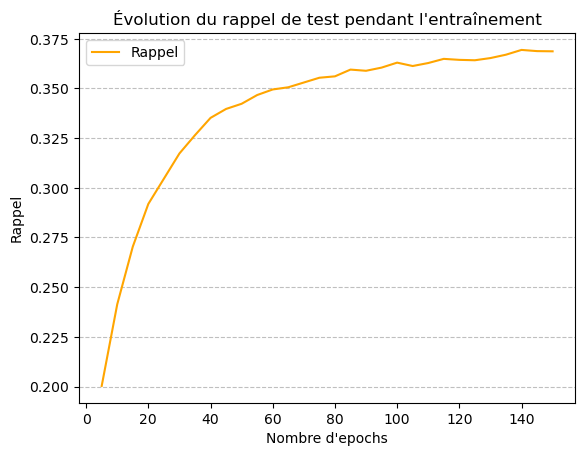

In [50]:
epoch_list = [(i+1)*every_k_epoch for i in range(int(EPOCHS/every_k_epoch))]
plt.plot(epoch_list, recall_list, label='Rappel', color = 'Orange')
plt.xlabel("Nombre d'epochs")
plt.ylabel('Rappel')
plt.title("Évolution du rappel de test pendant l'entraînement")
plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)
plt.legend()

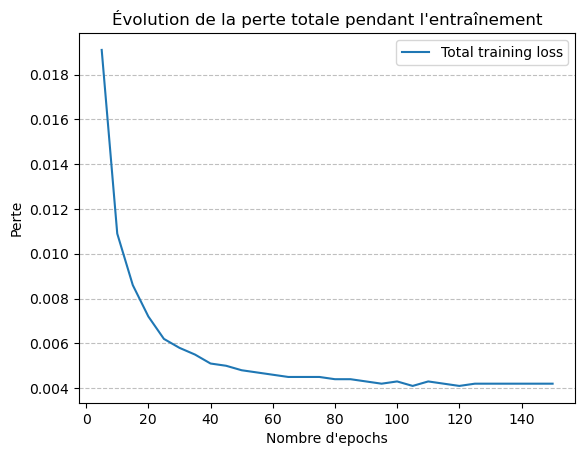

In [51]:
plt.plot(epoch_list, loss_list_epoch, label='Total training loss')
plt.xlabel("Nombre d'epochs")
plt.ylabel('Perte')
plt.title("Évolution de la perte totale pendant l'entraînement")
plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)
plt.legend()

### Étape 6 - Génération des recommandations

In [52]:
# Fonction pour obtenir l'index correspondant à un ID donné
def id2idx(id_, df, id_name = 'article_id', idx_name = 'article_id_idx'):
    return df[df[id_name]==id_][idx_name].unique().item()

# Fonction pour obtenir l'ID correspondant à un index donné
def idx2id(idx_, df, id_name = 'reference_id', idx_name = 'reference_id_idx'):
    return df[df[idx_name]==idx_][id_name].unique().item()

# Fonction pour obtenir les N meilleures références recommandées pour un article donné
def topN(article_id, final_article_Embed, final_reference_Embed, n=100, train_df = train):
    # Convertir les article_id en indices d'articles
    article_id_idx = id2idx(article_id, train_df, id_name = 'article_id', idx_name = 'article_id_idx')

    # Calculer les scores de similarité entre l'article et toutes les références et obtenir les N meilleures références
    scores = torch.squeeze(final_article_Embed[article_id_idx] @ final_reference_Embed.t())
    reference_id_idx, reference_scores = torch.topk(scores, k=n).indices, torch.topk(scores, k=n).values

    # Convertir les indices des références en reference_id
    reference_id = [idx2id(i.item(), train_df, id_name = 'reference_id', idx_name = 'reference_id_idx') for i in reference_id_idx]
    return reference_id

In [53]:
best_article_Embed = torch.load("final_article_Embed.pt")
best_reference_Embed = torch.load("final_reference_Embed.pt")

recommandation_lightGCN = []

for id_ in tqdm(test_nodes_ids_list):
    topN_filtered = topN(id_, best_article_Embed, best_reference_Embed, n=100)
    topN_filtered = [i for i in topN_filtered if not i in np.array(list(G_directed.successors(id_ - 1)))+1 and i != id_][:20]
    recommandation_lightGCN.append({'Article_id' : id_, 'Recommendations' : topN_filtered})

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.55it/s]


In [54]:
pd.DataFrame(recommandation_lightGCN)

,Article_id,Recommendations
0,34,"[99, 66, 391, 42, 546, 392, 41, 549, 98, 332, 51, 142, 521, 53, 852, 558, 561, 483, 417, 3410]"
1,316,"[142, 404, 147, 2895, 318, 300, 2910, 27, 432, 311, 2922, 1569, 317, 6192, 305, 302, 18773, 18709, 3661, 2152]"
2,469,"[99, 391, 105, 66, 100, 852, 392, 549, 332, 546, 645, 478, 473, 804, 435, 455, 51, 926, 95, 561]"
3,687,"[26, 59, 238, 181, 713, 759, 1219, 742, 18714, 117, 772, 286, 783, 751, 686, 90, 670, 728, 1185, 729]"
4,738,"[218, 1105, 391, 1194, 26, 66, 811, 939, 3974, 3449, 773, 5728, 367, 942, 901, 334, 3230, 363, 5955, 6133]"
...,...,...
95,17877,"[2691, 2692, 3866, 322, 4677, 4049, 3790, 4051, 11265, 4625, 6466, 725, 13422, 11264, 5898, 15278, 22728, 994, 3773, 11305]"
96,18168,"[4237, 18573, 19002, 4259, 4241, 23359, 20657, 468, 4239, 3517, 8213, 16299, 4263, 4258, 4245, 23499, 25586, 28396, 19000, 20736]"
97,18295,"[10785, 22710, 22717, 322, 18284, 4052, 3879, 22711, 21641, 22734, 22708, 22707, 5878, 719, 45025, 16692, 22723, 15250, 2975, 22715]"
98,18344,"[1641, 1163, 1645, 1153, 1637, 1166, 468, 1170, 1650, 18545, 1169, 4946, 1147, 18712, 9920, 7258, 18788, 11139, 66292, 1165]"


In [1]:
print(f"LightGCN")
print(f"NDCG Score (Kaggle) : 0.27160")

LightGCN
NDCG Score (Kaggle) : 0.27160


## Algorithme Kaggle

Presentez ici l'approche qui vous donne vos meilleurs resultats sur Kaggle. Si c'est l'une des approches precedente, indiquez laquelle.

Pour la compétition Kaggle, nous avons décidé de combiner les forces de différents algorithmes présentés précédemment (PageRank personnalisé, filtrage collaboratif, approche contenu, etc.). Pour chaque article cible, nous appliquons la procédure suivante :

- Nous utilisons d'abord un PageRank personnalisé pour extraire les 100 références les plus pertinentes. Cette approche nous permet d'identifier les nœuds les plus importants en fonction de leur connectivité à l’article cible.

- Ensuite, nous éliminons toutes les références publiées après l’article cible. Ceci garantit le respect des contraintes temporelles (Par principe, un article ne peut pas citer un travail future). Parmi les références restantes, nous conservons les 20 plus pertinentes.

- Enfin, nous réordonnons ces 20 références à l’aide de la similarité cosinus, en comparant leurs représentations vectorielles à celle de l’article cible.

In [56]:
# PageRank personnalisé - Graphe non orienté
G_undirected = nx.from_numpy_array(M, create_using=nx.Graph())

test_idxs = (node_ids_test_csv['idx'] - 1).tolist()
recommendation_prp_undirected_top100 = []

for i, test_idx in tqdm(enumerate(test_idxs)):
    neighbors_list =  list(G_undirected.neighbors(test_idx))

    pagerank_scores = nx.pagerank(G_undirected,
                                  personalization={node: 1/len(neighbors_list) if node in neighbors_list else 0 for node in G_undirected.nodes()})

    pagerank_scores[test_idx] = 0

    for item in pagerank_scores:
        if item in neighbors_list:
            pagerank_scores[item] = 0

    sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_articles_idx = [i[0] for i in sorted_pagerank][:100]

    recommendation_prp_undirected_top100.append({'Article_id' : test_idx+1, 'Recommendations' : [i+1 for i in sorted_articles_idx]})

100it [02:05,  1.25s/it]


In [57]:
# Supprimer les références publiées après l'article cible
recommendation_prp_undirected_y_excluded = []
for item in recommendation_prp_undirected_top100:
    test_year = articles_idx[articles_idx['n'] == item['Article_id']]['year'].values[0]
    filtered_list = np.array([
        j for j in item['Recommendations']
        if articles_idx[articles_idx['n'] == j]['year'].values[0] <= test_year][:20])
    recommendation_prp_undirected_y_excluded.append({'Article_id' : item['Article_id'], 'Recommendations' : filtered_list.tolist()})

In [58]:
# Réordonner les 20 articles les plus pertinents en utilisant la similarité cosinus
# Construire la matrice M_MT_sparse en ajoutant M_sparse et sa transposée MT_sparse
M_sparse = csr_matrix(M)
MT_sparse = M_sparse.copy().T
M_MT_sparse = M_sparse + MT_sparse

# Pour chaque article cible, calculer la similarité cosinus entre l'article et ses articles recommandés
similarity_score = []
recommendation_list = []
for item in recommendation_prp_undirected_y_excluded:
    recommendation_list.append(item['Recommendations'])
    cos_sim = cosine_similarity(
        M_MT_sparse[np.array([item['Article_id']-1])],
        M_MT_sparse[np.array(item['Recommendations'])-1, :], dense_output=False).tolil()
    similarity_score.append(cos_sim)

recommendation_prp_undirected_y_excluded_rerank = []

# Réordonner les articles en fonction des scores de similarité
recommendation_prp_undirected_y_excluded_rerank = []

for i,test_idx in enumerate(test_idxs):
    sorted_similarity = np.argsort(similarity_score[i].toarray()[0])[::-1]
    recommendation_prp_undirected_y_excluded_rerank.append({'Article_id': test_idx+1, 'Recommendations': [recommendation_list[i][j] for j in sorted_similarity]})

In [59]:
pd.DataFrame(recommendation_prp_undirected_y_excluded_rerank)

,Article_id,Recommendations
0,34,"[42, 41, 19062, 546, 98, 549, 3410, 53, 66, 147, 392, 142, 99, 51, 15, 214, 26, 391, 97, 130]"
1,316,"[307, 305, 317, 147, 2282, 21034, 2639, 4979, 318, 42404, 300, 404, 5266, 20813, 7829, 46, 11439, 142, 2895, 258]"
2,469,"[19786, 473, 4033, 4683, 6710, 417, 21277, 66, 435, 549, 99, 42, 804, 543, 391, 1028, 498, 3866, 105, 214]"
3,687,"[1219, 183, 670, 286, 772, 713, 222, 90, 59, 181, 742, 1176, 26, 117, 400, 759, 783, 1162, 74, 390]"
4,738,"[1105, 773, 6133, 5991, 939, 5955, 8711, 7058, 218, 1194, 5728, 6020, 26, 1107, 2305, 23634, 391, 3974, 66, 353]"
...,...,...
95,17877,"[66462, 46946, 22660, 1828, 40831, 11264, 46952, 13422, 6466, 725, 6402, 3783, 47380, 2692, 4677, 3790, 4053, 3866, 2691, 4049]"
96,18168,"[28396, 23359, 20278, 61945, 23278, 44112, 4241, 3517, 4239, 20239, 1644, 3638, 41276, 16785, 10518, 1152, 3521, 3371, 1240, 1519]"
97,18295,"[10785, 24252, 22707, 22710, 22711, 4052, 11324, 22699, 22708, 22715, 3879, 13125, 52066, 45025, 28327, 22717, 21641, 61745, 322, 15239]"
98,18344,"[1169, 7258, 1647, 1158, 1170, 1160, 1645, 1147, 18346, 1144, 18341, 1166, 1163, 1641, 1153, 1650, 1165, 46440, 1644, 1637]"


In [60]:
import csv
with open('recommandations.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id','recommandations'])

    for item in recommendation_prp_undirected_y_excluded_rerank:
        test_id = node_ids_csv[node_ids_csv['n'] == item['Article_id']]['id'].values[0]
        recmmendations_ids = [node_ids_csv[node_ids_csv['n'] == i]['id'].values[0] for i in item['Recommendations']]
        recommendations_str = " ".join(map(str, recmmendations_ids))
        writer.writerow([test_id, recommendations_str])

In [61]:
print(f"Kaggle")
print(f"NDCG Score (Kaggle) : 0.34866")

Kaggle
NDCG Score (Kaggle) : 0.34866


## Conclusion

### Comparaison des performances (sur les vraies données de test - Kaggle)

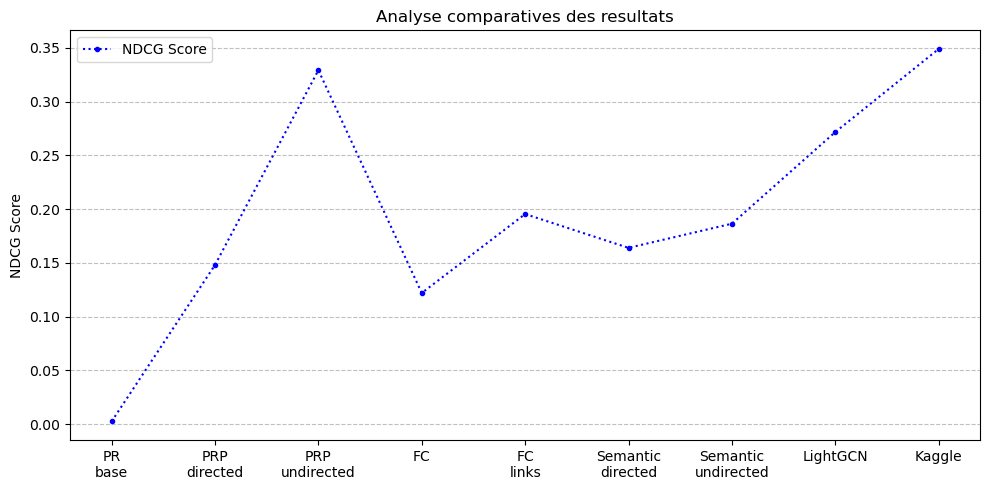

In [2]:
fig, ax = plt.subplots(figsize=(10, 5))
ndcg_score = [0.00260, 0.14807, 0.32912, 0.12201, 0.19541, 0.16397, 0.18643, 0.27160, 0.34886]

ax.plot(range(len(ndcg_score)), ndcg_score, marker='.', color='blue', linestyle=':', label="NDCG Score")
ax.set_ylabel('NDCG Score')
ax.set_title('Analyse comparatives des resultats')
ax.set_xticks(range(len(ndcg_score)))
ax.set_xticklabels([label.replace('_', '\n') for label in ['PR_base', 'PRP_directed', 'PRP_undirected',
                                                         'FC', 'FC_links',
                                                         'Semantic_directed', 'Semantic_undirected',
                                                         'LightGCN',
                                                         'Kaggle']])

ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

- L'approche Kaggle surpasse nettement les autres méthodes, grâce à une combinaison des forces de différents algorithmes.

- PRP_undirected montre qu'une version non dirigée du PageRank personnalisé capture mieux les relations implicites dans un graphe de citations. Au contraire, PRP_directed offre des performances moins désirables (0.32912 vs 0.14807).

- LightGCN offre des performances honorables pour un modèle entraîné, bien qu'il se limite à l'agrégation des informations des voisins directs (jusqu’à 3 sauts).

- Semantic_undirected et Semantic_directed : L'approche contenu avec augmentation sémantique offre des performances acceptables, bien que ça soit un peu inférieur au filtrage collaboratif (avec l'intégration de liens supplémentaires).

- FC et FC_links : Le filtrage collaboratif basé sur la similarité cosinus offre des performances acceptables également. Toutefois, FC_links obtient de meilleurs résultats grâce à l'intégration de liens supplémentaires.

- PR_base n’arrive pas à capturer les relations implicites entre les articles, ce qui confirme la nécessité d’un PageRank personnalisé.

### Comparaison des performances (sur les données échantillonnées)

Pour comparer les trois premières méthodes de manière locale, nous avons calculé la précision sur un sous-ensemble d’articles sélectionné précédemment (différent du jeu de test). Les références, ou ground truth, sont constituées des successeurs de chaque nœud dans ce sous-ensemble, tandis que les prédictions correspondent aux recommandations retournées par chaque méthode.
Des ajustements ont été apportés aux méthodes pour permettre cette évaluation locale, notamment en n’excluant pas les successeurs des prédictions, contrairement à ce qui avait été fait pour les évaluations finales. Les résultats obtenus sont les suivants :
* L’algorithme PageRank personnalisé appliqué sur le graphe non orienté affiche une bonne précision de 0.4025, surpassant les trois autres méthodes.
* Le filtrage collaboratif utilisant une matrice enrichie atteint une précision de 0.135 relativement acceptable.
* L’approche contenu avec augmentation sémantique, par contre, obtient des résultats très faibles sur ces données locales, avec une précision de 0.0055 pour la version orientée du graphe, et 0.0045 pour la version non orientée. Bien que la précision soit relativement faible, le score NDCG obtenu reste acceptable, ce qui indique que cette approche classe correctement les meilleurs résultats en tête de liste. Cela pourrait s’expliquer par les ajustements appliqués dans le cadre de cette évaluation locale. De plus, certains nœuds du sous-ensemble, comme le nœud 43030 (ou 43029 dans le graphe), ne possèdent aucun successeur, ce qui impacte négativement les résultats.

Concernant LightGCN, son évaluation locale diffère légèrement, puisqu’il s’agit d’un modèle entraîné, contrairement aux approches précédentes. Sa performance a été mesurée à l’aide de l’ensemble de test mis de côté lors de la séparation des données en entraînement et test. En fin d’entraînement, le modèle atteint un rappel de 0.37, ce qui représente une performance très satisfaisante.

### Discussion (Forces)

- Le PageRank personnalisé permet, via le vecteur d'atténuation, d'apporter plus d'attention sur les articles plus pertinents pour l'article cible. Ceci permet d'augmenter la probabilité d'attérir sur les articles référencés.
- L'approche collaborative est capables d'identifier deux articles ayant des références communes comme étant similaires même en l'absence de citations directes entre eux. De plus, Elle est relativement simple à mettre en place et le temps d'exécution est court.
- L'approche contenu avec augmentation sémantique prend en considération le contexte. Elle se base sur la compréhension du sens des titres des articles plutôt que sur une comparaison de mots-clés. De plus, la partie contenu permet d'exploiter l'attribut 'Année de publication' pour un filtrage plus fin. Finalement, elle est adaptable et facile à implémenter.
- LightGCN est une approche modèle. Il est plus léger que les GCN traditionnels en raison de suppression de la non-linéarité. De plus, il est capable de cpaturer des relations plus complexes en intégrant les informations des noeuds connectés et de leurs successeurs.

### Discussion (Faiblesses)

- Le PageRank favorise parfois les articles populaires. Cela peut conduire à une recommandation biaisée en faveur d'articles cités plus fréquemment.
- Lorsque la matrice d'ajacence est creuse, il devient difficle de trouver des articles similaires en utilisant l'approche collaborative. Ceci dégrage la qualité des articles recommandés.
- Pour l'approche contenu, l'augmentation sémantique toute seule ne donne pas de très bon résultats. Elle retourne des articles ayant des titres sémantiquement similaires mais pas nécessairement des citations. Le filtrage des articles similaires est nécessaire pour obtenir de bons résultats.
- Comparé aux méthodes précédentes, LightGCN est coûteux en ressources. Il est plus difficile à implémenter. De plus, il se concentre principalement sur l'agrégation d'informations locales (jusqu’à 3 sauts), ce qui peut entraîner des difficultés pour capturer des relations à longue portée.

### Difficultés

- Les articles de notre base de données couvrent des thématiques très similaires, telles que l'apprentissage machine, les systèmes distribués, etc. Par exemple, deux articles dans le domaine de l'apprentissage machine peuvent avoir des titres similaires (contenant par exemple "model" ou "neural"), mais leurs sous-thèmes peuvent être très différents (par exemple, NLP vs. clustering), ce qui fait que les articles qu'ils référencent peuvent être totalement distincts.
- Nous avons tenté d'utiliser les résumés des articles pour améliorer la précision de notre approche, mais après investigation, nous avons constaté que ces résumés sont indisponibles pour de nombreux articles.
- Échantillonnage négatif pour LightGCN : L'échantillonnage négatif est utilisé pour générer des exemples négatifs pour l'entraînement du modèle. Le nombre élevé d'articles dans le graphe ralentit le processus d'échantillonnage négatif. Ainsi, un sous-ensemble d'articles est présélectionné toutes les 5 époques pour effectuer cet échantillonnage.
- Nous avons pensé à intégrer les auteurs pour enrichir le graphe de citations mais nous avons été contraint pas le grand nombre d'auteurs disponibles dans la base de données. Nous avions également des doutes sur la méthode appropriée pour exploiter correctement le nouveau graphe hétérogène.